In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
n = 8
qc_output = QuantumCircuit(n,n)
for j in range(n):
    qc_output.measure(j,j)

qc_output.draw(output='mpl')

<Figure size 1588.61x1362.86 with 1 Axes>

This is a classical addition


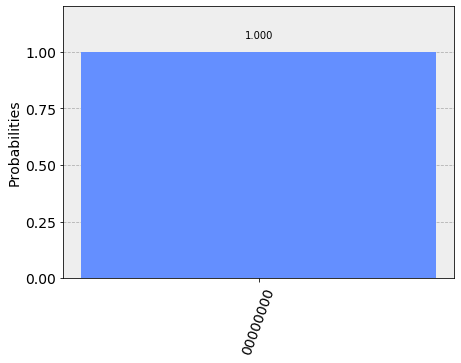

In [2]:
counts = execute(qc_output,Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

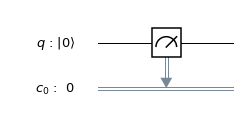

In [3]:
measure_z = QuantumCircuit(1,1)
measure_z.measure(0,0)

measure_z.draw(output='mpl')

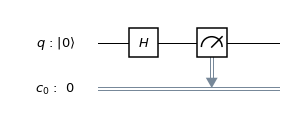

In [4]:
measure_x = QuantumCircuit(1,1)
measure_x.h(0)
measure_x.measure(0,0)

measure_x.draw(output='mpl')

Results for x measurement:


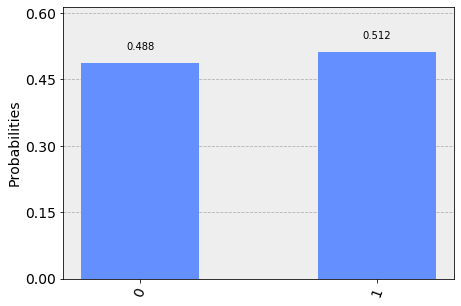

In [5]:
qc_0 = QuantumCircuit(1)

qc_0.draw(output='mpl')
qc = qc_0 +  measure_x

print('Results for x measurement:')
counts = execute(qc,Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

Shared randomness

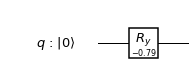

In [6]:
qc_y = QuantumCircuit(1)
qc_y.ry( -3.14159/4,0)

qc_y.draw(output='mpl')

Results for z measurement:


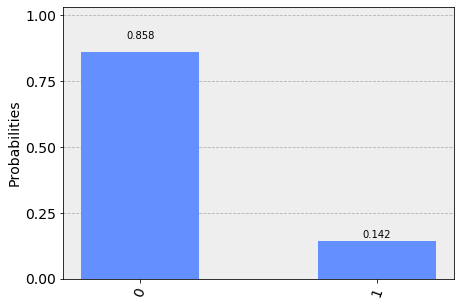

In [7]:
qc = qc_y + measure_z

print('Results for z measurement:')
counts = execute(qc,Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

    Uncertainity

In [8]:
shots = 2**14 # number of samples used for statistics

uncertainty = 0
for measure_circuit in [measure_z, measure_x]:

    # run the circuit with a the selected measurement and get the number of samples that output each bit value
    counts = execute(qc+measure_circuit,Aer.get_backend('qasm_simulator'),shots=shots).result().get_counts()

    # calculate the probabilities for each bit value
    probs = {}
    for output in ['0','1']:
        if output in counts:
            probs[output] = counts[output]/shots
        else:
            probs[output] = 0
            
    uncertainty += ( probs['0'] -  probs['1'] )**2

# print the total uncertainty
print('The total uncertainty is',uncertainty )

The total uncertainty is 0.4948488473892212


In [9]:
from qiskit import *
from qiskit.visualization import plot_bloch_vector

In [10]:
# z measurement of qubit 0
measure_z = QuantumCircuit(1,1)
measure_z.measure(0,0);

# x measurement of qubit 0
measure_x = QuantumCircuit(1,1)
measure_x.h(0)
measure_x.measure(0,0)

# y measurement of qubit 0
measure_y = QuantumCircuit(1,1)
measure_y.sdg(0)
measure_y.h(0)
measure_y.measure(0,0);

In [11]:
shots = 2**14 # number of samples used for statistics

bloch_vector = []
for measure_circuit in [measure_x, measure_y, measure_z]:
    
    # run the circuit with a the selected measurement and get the number of samples that output each bit value
    counts = execute(qc+measure_circuit,Aer.get_backend('qasm_simulator'),shots=shots).result().get_counts()

    # calculate the probabilities for each bit value
    probs = {}
    for output in ['0','1']:
        if output in counts:
            probs[output] = counts[output]/shots
        else:
            probs[output] = 0
            
    bloch_vector.append( probs['0'] -  probs['1'] )

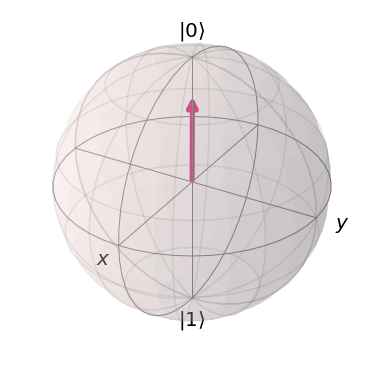

In [12]:
plot_bloch_vector( bloch_vector )

In [13]:
# set up circuit (no measurements required)
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.rz(3.14/4,1)

# set up simulator that returns statevectors
backend = Aer.get_backend('statevector_simulator')

# run the circuit to get the state vector
state = execute(qc,backend).result().get_statevector()

# now we use some fanciness to display it in latex
from IPython.display import display, Markdown, Latex
def state2latex(state):
    state_latex = '\\begin{pmatrix}'
    for amplitude in state:
        state_latex += str(amplitude) + '\\\\'
    state_latex  = state_latex[0:-4]
    state_latex += '\end{pmatrix}'
    display(Markdown(state_latex))

state2latex(state)

\begin{pmatrix}(0.5000000000000001+0j)\\(0.5+0j)\\(0.3536941345835999+0.353412590552683j)\\(0.35369413458359983+0.3534125905526829\end{pmatrix}

## Teleportation


In [22]:

# make the imports that are necessary for our work
import qiskit as qk
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit import IBMQ
from qiskit.tools.visualization import plot_histogram

secret_unitary = 'zyzyzyzy'

In [23]:
# simple function that applies a series of unitary gates from a given string
def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    functionmap = {
                    'x':quantum_circuit.x,
                    'y':quantum_circuit.y,
                    'z':quantum_circuit.z,
                    'h':quantum_circuit.h,                    
                    't':quantum_circuit.t,                    
    }
    if dagger: functionmap['t'] = quantum_circuit.tdg
    
    if dagger:
        [functionmap[unitary](qubit) for unitary in secret_unitary]
    else:
        [functionmap[unitary](qubit) for unitary in secret_unitary[::-1]]

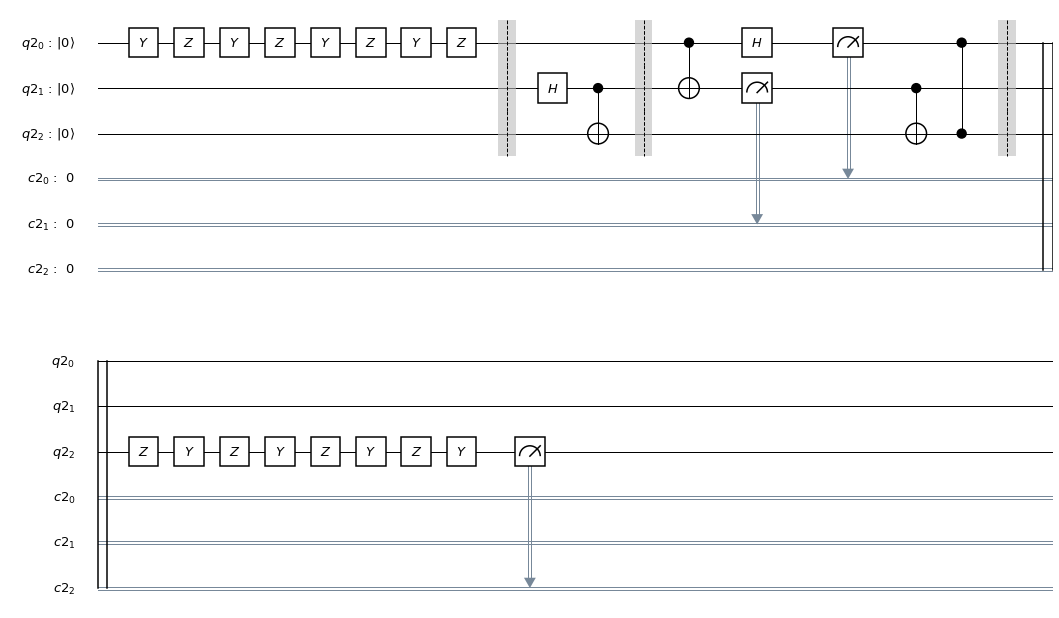

In [24]:
# Create the quantum circuit
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)

''' Qubit ordering as follows (classical registers will just contain measured values of the corresponding qubits):
q[0]: qubit to be teleported (Alice's first qubit. It was given to her after the application of a secret unitary 
      which she doesn't know)
q[1]: Alice's second qubit
q[2]: Bob's qubit, which will be the destination for the teleportation
'''

# Apply the secret unitary that we are using to generate the state to teleport. You can change it to any unitary
apply_secret_unitary(secret_unitary, q[0], qc, dagger = 0)
qc.barrier()
# Next, generate the entangled pair between Alice and Bob (Remember: Hadamard followed by CX generates a Bell pair)
qc.h(q[1])
qc.cx(q[1], q[2])
qc.barrier()
# Next, apply the teleportation protocol. 
qc.cx(q[0], q[1])
qc.h(q[0])
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.cx(q[1], q[2])
qc.cz(q[0], q[2])
qc.barrier()

'''
In principle, if the teleportation protocol worked, we have q[2] = secret_unitary|0>
As a result, we should be able to recover q[2] = |0> by applying the reverse of secret_unitary
since for a unitary u, u^dagger u = I.
'''
apply_secret_unitary(secret_unitary, q[2], qc, dagger=1)
qc.measure(q[2], c[2])
qc.draw(output='mpl')

{'011': 262, '010': 254, '000': 248, '001': 260}


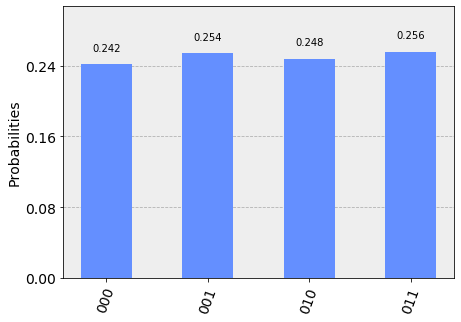

In [17]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)